### Tutorial notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/datatest2.txt')

Dx = data["date"]

data['date'] = data.date.astype('datetime64[ns]')
data = data.set_index('date')

data.tail()

Temperature  Humidity   Light      CO2  HumidityRatio  \
date                                                                         
2015-02-18 09:15:00       20.815   27.7175  429.75  1505.25       0.004213   
2015-02-18 09:16:00       20.865   27.7450  423.50  1514.50       0.004230   
2015-02-18 09:16:59       20.890   27.7450  423.50  1521.50       0.004237   
2015-02-18 09:17:59       20.890   28.0225  418.75  1632.00       0.004279   
2015-02-18 09:19:00       21.000   28.1000  409.00  1864.00       0.004321   

                     Occupancy  
date                            
2015-02-18 09:15:00          1  
2015-02-18 09:16:00          1  
2015-02-18 09:16:59          1  
2015-02-18 09:17:59          1  
2015-02-18 09:19:00          1

### Data represents measurements in **conference** room in ***time***

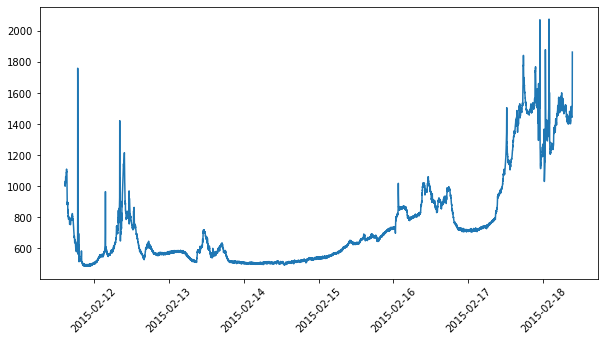

In [2]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
%matplotlib inline

#data['Occupancy'] = 100*data['Occupancy']
plt.figure(figsize=(10,5));
plt.plot(data.CO2);
plt.xticks(rotation=45);
#plt.ylabel('Temperature',fontsize = 20)

plt.show()

In [3]:
T = (data.Temperature-min(data.Temperature))
T = T/max(T)
H = (data.Humidity-min(data.Humidity))
H = H/max(H)
L = (data.Light-min(data.Light))
L = L/max(L)
C = (data.CO2-min(data.CO2))
C = C/max(C)

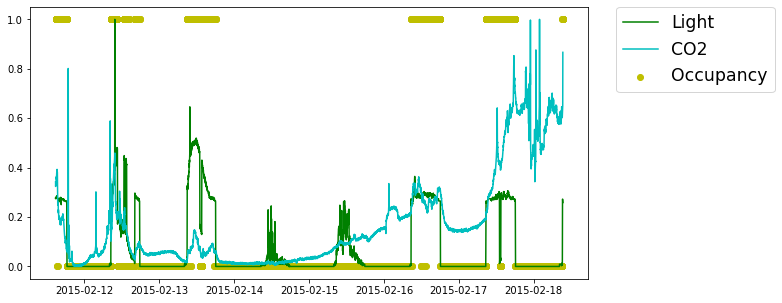

In [4]:
plt.figure(figsize=(10,5))
#Temp = plt.plot(T,'b',label = 'Temperature')
#Humid = plt.plot(H,'r',label = 'Humidity')
Light = plt.plot(L,'g',label = 'Light')
CO = plt.plot(C,'c',label = 'CO2')
Occup = plt.scatter(Dx,data.Occupancy,c = 'y',label = 'Occupancy')
plt.legend(fontsize = 'xx-large',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

### Finding outliers in the data

In [5]:
def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) 
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=50, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

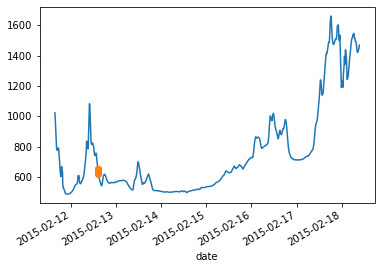

In [6]:
find_outliers(variable='CO2', window=50, sigma=10)

## Using [Panel](https://panel.holoviz.org/index.html) to make the visualisation more interactive:

Column
    [0] Column
        [0] IntSlider(end=150, name='window', start=-50, value=50)
        [1] IntSlider(end=30, name='sigma', start=-10, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00101')
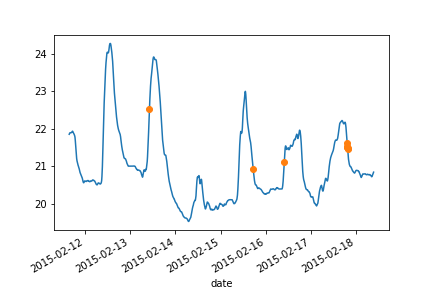

In [7]:
import panel as pn
pn.extension()

pn.interact(find_outliers)

In [8]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
#i.pprint()

Row
    [0] Matplotlib(Figure, name='interactive00114')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=50)
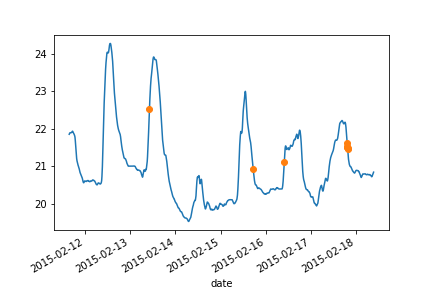

In [9]:
text = "<br>\n# Room Occupancy\nSelect the variable, and the time window for smoothing"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

In [10]:
i[0][2]

IntSlider(end=20, name='sigma', start=1, value=10)

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10)
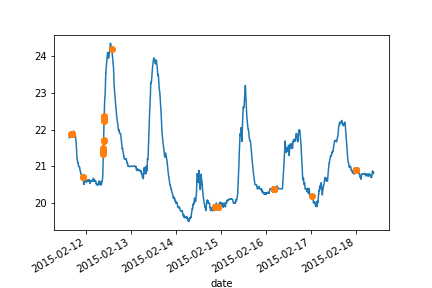

In [11]:
import panel.widgets as pnw

variable  = pnw.RadioButtonGroup(name='variable', value='Temperature', 
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

reactive_outliers = pn.bind(find_outliers, variable, window, 10)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy

In [12]:
import param

class RoomOccupancy(param.Parameterized):
    variable  = param.Selector(objects=list(data.columns))
    window    = param.Integer(default=10, bounds=(1, 20))
    sigma     = param.Number(default=10, bounds=(0, 20))

    def view(self):
        return find_outliers(self.variable, self.window, self.sigma)
    
obj = RoomOccupancy()
obj

RoomOccupancy(name='RoomOccupancy00147', sigma=10, variable='Temperature', window=10)

Row
    [0] Column(margin=5, name='RoomOccupancy', width=300)
        [0] StaticText(value='<b>RoomOccupancy</b>')
        [1] Select(name='Variable', options=OrderedDict([('Temperature...]), value='Temperature')
        [2] IntSlider(end=20, name='Window', start=1, value=10)
        [3] FloatSlider(end=20, name='Sigma', value=10)
    [1] ParamMethod(method)
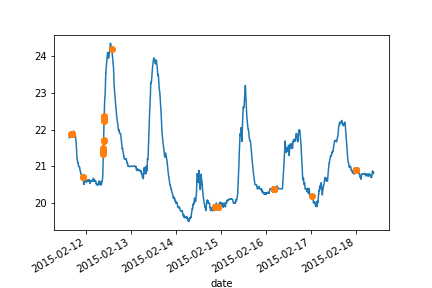

In [13]:
pn.Row(obj.param, obj.view)

In [14]:
import hvplot.pandas

def hvplot(avg, highlight):
    return avg.hvplot(height=200) * highlight.hvplot.scatter(color='orange', padding=0.1)

text2 = "## Room Occupancy\nSelect the variable and the smoothing values"
hvp   = pn.interact(find_outliers, view_fn=hvplot, **kw)
pn.Column(pn.Row(pn.panel(text2, width=400), hvp[0]), hvp[1]).servable("Occupancy")

Column
    [0] Row
        [0] Markdown(str, width=400)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=50)
            [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] HoloViews(Overlay, name='interactive01621')

In [15]:
import holoviews as hv

tap = hv.streams.PointerX(x=data.index.min())

def hvplot2(avg, highlight):
    line = avg.hvplot(height=300, width=500)
    outliers = highlight.hvplot.scatter(color='orange', padding=0.1)
    tap.source = line
    return (line * outliers).opts(legend_position='top_right')

@pn.depends(tap.param.x)
def table(x):
    index = np.abs((data.index - x).astype(int)).argmin()
    return data.iloc[index]

app = pn.interact(find_outliers, view_fn=hvplot2, **kw)

pn.Row(
    pn.Column("## Room Occupancy\nHover over the plot for more information.", app[0]),
    pn.Row(app[1], table)
)

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
            [1] IntSlider(end=60, name='window', start=1, value=50)
            [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Row
            [0] HoloViews(Overlay, name='interactive02094')
        [1] ParamFunction(function)